In [1]:
import torch;
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
class Convolutional_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=288, out_features=2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=2, out_features=288),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
print(Convolutional_Autoencoder())
print(summary(Convolutional_Autoencoder().to(device), (1, 28, 28)))

Convolutional_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=288, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape

In [16]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

In [27]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:,  dim1], z[:,  dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [32]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [44]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

data = datasets.MNIST('./data',transform=transform,download=True)

n, w, h = data.data.shape

data_loader = torch.utils.data.DataLoader(data,batch_size=128,shuffle=True)

model = Convolutional_Autoencoder()

optimizer = torch.optim.Adam(model.parameters())
    
loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function,20)

0/0: 0.24962538480758667
0/100: 0.07037315517663956
0/200: 0.06752568483352661
0/300: 0.060225147753953934
0/400: 0.06041165813803673
1/0: 0.05883578956127167
1/100: 0.05832000821828842
1/200: 0.05675386264920235
1/300: 0.05399153009057045
1/400: 0.05673721060156822
2/0: 0.0554468110203743
2/100: 0.05135881528258324
2/200: 0.05498221516609192
2/300: 0.05519304424524307
2/400: 0.0525764636695385
3/0: 0.053251732140779495
3/100: 0.05167914554476738
3/200: 0.05058155208826065
3/300: 0.0508648119866848
3/400: 0.052560631185770035
4/0: 0.05043499916791916
4/100: 0.05128539353609085
4/200: 0.050797563046216965
4/300: 0.046958062797784805
4/400: 0.0519181452691555
5/0: 0.04970160126686096
5/100: 0.04943066090345383
5/200: 0.05004309490323067
5/300: 0.05158672481775284
5/400: 0.04740395396947861
6/0: 0.04999809339642525
6/100: 0.04572073742747307
6/200: 0.050529349595308304
6/300: 0.048582058399915695
6/400: 0.050967417657375336
7/0: 0.04859945550560951
7/100: 0.049013227224349976
7/200: 0.048

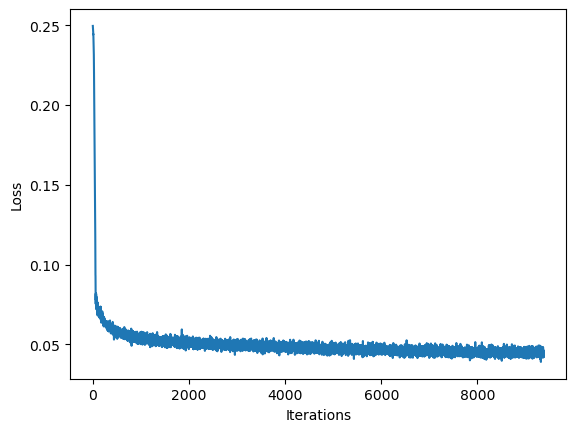

In [45]:
 # Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the losses
plt.plot(losses)

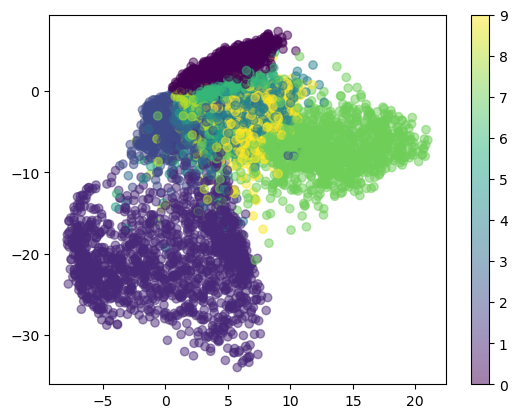

In [46]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)

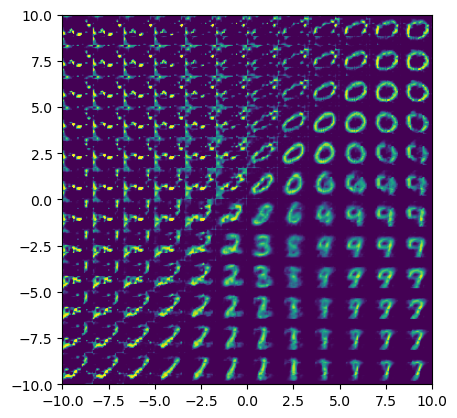

In [47]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)